In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
import pyroc
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample
from statsmodels.stats.contingency_tables import mcnemar

def add_weight_ave(df):
    df['image_clinical2'] = df['image'] * 0.8 + df['clinical'] * 0.2
    df.loc[df['clinical'].isnull(), 'image_clinical2'] = df['image']
    return df

def get_tpr_fpr(df, variable, threshold):
    total_positive = (df['Final_Dx'] == 1).sum()
    true_positive = (
        (df[variable] >= threshold) & (df['Final_Dx'] == 1)).sum()
    total_negative =  (df['Final_Dx'] == 0).sum()
    false_positive = (
        (df[variable] >= threshold) & (df['Final_Dx'] == 0)).sum()
    tpr = true_positive / total_positive
    fpr = false_positive / total_negative
    return tpr, fpr

def print_tpr_fpr(var_name, var_tpr, var_fpr, total_positive, total_negative):
    ''' print in this format
        varible name tpr, fpr: 0.758 [100/132], 0.056 [15/268]
    '''
    print(
        var_name
        + ' tpr, fpr: '
        + '{0:.3f}'.format(var_tpr)
        + ' ('
        + '{0:.0f}'.format(var_tpr * total_positive)
        + '/'
        + '{0:.0f}'.format(total_positive)
        + '), '
        + '{0:.3f}'.format(var_fpr)
        + ' ('
        + '{0:.0f}'.format(var_fpr * total_negative)
        + '/'
        + '{0:.0f}'.format(total_negative)
        + ')'
        )

def print_var_95ci(var_name, var1, var2, var3):
    ''' print in this format
        variable name: 0.774 [0.704 0.845]
    '''
    print(
        var_name
        + ': '
        + '{0:.3f}'.format(var1)
        + ' (95% CI: '
        + '{0:.3f}'.format(var2)
        + ', '
        + '{0:.3f}'.format(var3)
        + ')'
        )

def McNemar_test(test1, test2, y, exact=True, correction=True):
    table = np.zeros((2,2))
    table[0, 0] = ((test1 == y) & (test2 == y)).sum()
    table[1, 0] = ((test1 == y) & (test2 != y)).sum()
    table[0, 1] = ((test1 != y) & (test2 == y)).sum()
    table[1, 1] = ((test1 != y) & (test2 != y)).sum()
    results = mcnemar(table, exact=exact, correction=correction)
    return results.statistic, results.pvalue

In [2]:
fn_val = '../../OneDrive - Mayo Clinic/Prostate/Classification Jason/Jason_rev_dataset/Jan23_13h46m22s_PREDICT_VALID300new.csv'
fn_test = '../../OneDrive - Mayo Clinic/Prostate/Classification Jason/Jason_rev_dataset/Jan23_13h20m34s_PREDICT_COMBINED400new.csv'
fn_test_external = '../../OneDrive - Mayo Clinic/Prostate/Classification Jason/Jason_rev_dataset/Aug27_00h09m00s_PREDICT_IMGONLY204.csv'
df_val = pd.read_csv(fn_val)
df_test = pd.read_csv(fn_test)
df_test_external = pd.read_csv(fn_test_external)
df_val = df_val.rename(
    columns={'image_preds': 'image',
             'clinical_preds': 'clinical',
             'composite_preds': 'image_clinical1'})
df_test = df_test.rename(
    columns={'image_preds': 'image',
             'clinical_preds': 'clinical',
             'composite_preds': 'image_clinical1'})
df_test_external = df_test_external.rename(
    columns={'image_preds': 'image'})

In [3]:
df_val_w_PSA = df_val[~df_val['clinical'].isnull()]

In [4]:
model_0 = LogisticRegression(C=100).fit(
    df_val_w_PSA[['image', 'clinical']], df_val_w_PSA['Final_Dx'])
df_val.loc[~df_val['clinical'].isnull(),'image_clinical2'] = (
    model_0.predict_proba(
        df_val.loc[~df_val['clinical'].isnull(),
                    ['image', 'clinical']])[:, 1])
df_test.loc[~df_test['clinical'].isnull(),'image_clinical2'] = (
    model_0.predict_proba(
        df_test.loc[~df_test['clinical'].isnull(),
                    ['image', 'clinical']])[:, 1])
# if clinical data is absent, use image prediction
df_val.loc[df_val['clinical'].isnull(), 'image_clinical2'] = df_val['image']
df_test.loc[df_test['clinical'].isnull(), 'image_clinical2'] = df_test['image']

In [5]:
# fit model using PIRADS + image_clinical1 (or image_clinical2)
model_1 = LogisticRegression(C=100).fit(
    df_val[['image_clinical1', 'PIRADS']], df_val['Final_Dx'])
model_2 = LogisticRegression(C=100).fit(
    df_val[['image_clinical2', 'PIRADS']], df_val['Final_Dx'])
# predict in val set
df_val['image_clinical1_PIRADS'] = model_1.predict_proba(
    df_val[['image_clinical1', 'PIRADS']])[:, 1]
df_val['image_clinical2_PIRADS'] = model_2.predict_proba(
    df_val[['image_clinical2', 'PIRADS']])[:, 1]
# predict in test set
df_test['image_clinical1_PIRADS'] = model_1.predict_proba(
    df_test[['image_clinical1', 'PIRADS']])[:, 1]
df_test['image_clinical2_PIRADS'] = model_2.predict_proba(
    df_test[['image_clinical2', 'PIRADS']])[:, 1]

In [6]:
# fit model using PIRADS + image
model_3 = LogisticRegression(C=100).fit(
    df_val[['image', 'PIRADS']], df_val['Final_Dx'])
df_val['image_PIRADS'] = model_3.predict_proba(
    df_val[['image', 'PIRADS']])[:, 1]
df_test_external['image_PIRADS'] = model_3.predict_proba(
    df_test_external[['image', 'PIRADS']])[:, 1]

In [7]:
df_val_path_only = df_val[df_val['pathology'] != 'no pathology']
df_test_path_only = df_test[df_test['pathology']]

In [8]:
# list for internal test set
variable_list = [
    'image',
    'image_clinical1',
    'image_clinical2',
    'image_clinical1_PIRADS',
    'image_clinical2_PIRADS'
    ]
# list for external test set
variable_list2 = [
    'image',
    'image_PIRADS'
    ]
# dictionary to change variable names to labels
label_dict = {
    'PIRADS': 'Radiologist',
    'image': 'Image Only',
    'image_clinical1': 'Image+Clinical',
    'image_clinical1_PIRADS': 'Image+Clinical+Radiologist',
    'image_clinical2': 'Image+Clinical_LR',
    'image_clinical2_PIRADS': 'Image+Clinical+Radiologist_LR',
    'image_PIRADS': 'Image+Radiologist',
    'clinical': 'Clinical'
    }

In [9]:
print('val set, all cases')
# yoden threshold for each variable (calculated using all case data)
yoden_threshold_all = {}
for variable in variable_list + ['PIRADS']:
    fpr, tpr, threshold = metrics.roc_curve(
        df_val['Final_Dx'], df_val[variable])
    roc_auc = metrics.auc(fpr, tpr)
    yoden_threshold_all[variable] = threshold[np.argmax(tpr - fpr)]
    print(label_dict[variable])
    print('AUC: ' + '{0:.3f}'.format(roc_auc))
    print('Yoden Threshold: ' + '{0:.3f}'.format(yoden_threshold_all[variable]))

# yoden threshold for each variable (calculated using path only data)
print('val set, path proven cases')
yoden_threshold_path = {}
for variable in variable_list + ['PIRADS']:
    fpr, tpr, threshold = metrics.roc_curve(
        df_val_path_only['Final_Dx'], df_val_path_only[variable])
    roc_auc = metrics.auc(fpr, tpr)
    yoden_threshold_path[variable] = threshold[np.argmax(tpr - fpr)]
    print(label_dict[variable])
    print('AUC: ' + '{0:.3f}'.format(roc_auc))

# yoden threshold for image_PIRADS (for external test set)
fpr, tpr, threshold = metrics.roc_curve(
    df_val['Final_Dx'], df_val['image_PIRADS'])
roc_auc = metrics.auc(fpr, tpr)
yoden_threshold_all['image_PIRADS'] = threshold[np.argmax(tpr - fpr)]

val set, all cases
Image Only
AUC: 0.896
Yoden Threshold: 0.304
Image+Clinical
AUC: 0.899
Yoden Threshold: 0.376
Image+Clinical_LR
AUC: 0.906
Yoden Threshold: 0.352
Image+Clinical+Radiologist
AUC: 0.958
Yoden Threshold: 0.399
Image+Clinical+Radiologist_LR
AUC: 0.960
Yoden Threshold: 0.368
Radiologist
AUC: 0.937
Yoden Threshold: 3.000
val set, path proven cases
Image Only
AUC: 0.853
Image+Clinical
AUC: 0.855
Image+Clinical_LR
AUC: 0.865
Image+Clinical+Radiologist
AUC: 0.868
Image+Clinical+Radiologist_LR
AUC: 0.873
Radiologist
AUC: 0.789


test set all cases
total positive: 132, total negative: 268
Radiologist
AUC: 0.892
PIRADS3 tpr, fpr: 0.909 (120/132), 0.254 (68/268)
PIRADS4 tpr, fpr: 0.848 (112/132), 0.131 (35/268)
Image Only
AUC: 0.889
PIRADS3 equivalent tpr, fpr: 0.909 (120/132), 0.448 (120/268)
McNemar: P=0.00000
Yoden tpr, fpr: 0.788 (104/132), 0.160 (43/268)
McNemar: P=0.07637
Image+Clinical
AUC: 0.900
PIRADS3 equivalent tpr, fpr: 0.909 (120/132), 0.336 (90/268)
McNemar: P=0.04872
Yoden tpr, fpr: 0.780 (103/132), 0.123 (33/268)
McNemar: P=0.45702
Image+Clinical_LR
AUC: 0.907
PIRADS3 equivalent tpr, fpr: 0.902 (119/132), 0.332 (89/268)
McNemar: P=0.05073
Yoden tpr, fpr: 0.773 (102/132), 0.112 (30/268)
McNemar: P=0.62541
Image+Clinical+Radiologist
AUC: 0.935
PIRADS3 equivalent tpr, fpr: 0.909 (120/132), 0.243 (65/268)
McNemar: P=0.73588
Yoden tpr, fpr: 0.795 (105/132), 0.090 (24/268)
McNemar: P=0.57159
Image+Clinical+Radiologist_LR
AUC: 0.939
PIRADS3 equivalent tpr, fpr: 0.909 (120/132), 0.254 (68/268)
McNemar: P=

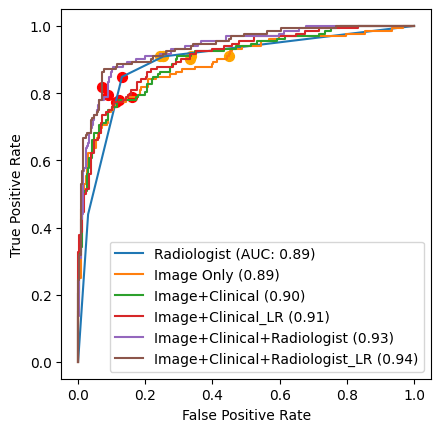

In [10]:
# all cases
print('test set all cases')
# total positive, total negative
total_positive = (df_test['Final_Dx'] == 1).sum()
total_negative = (df_test['Final_Dx'] == 0).sum()
print('total positive: '
      + str(total_positive)
      + ', total negative: '
      + str(total_negative))
# PIRADS, calculate
variable = 'PIRADS'
fpr, tpr, threshold = metrics.roc_curve(df_test['Final_Dx'], df_test[variable])
roc_auc = metrics.auc(fpr, tpr)
print(label_dict[variable])
print('AUC: ' + '{0:.3f}'.format(roc_auc))
PIRADS3_tpr, PIRADS3_fpr = tpr[3], fpr[3]
PIRADS4_tpr, PIRADS4_fpr = tpr[2], fpr[2]
print_tpr_fpr(
    'PIRADS3', PIRADS3_tpr, PIRADS3_fpr, total_positive, total_negative)
print_tpr_fpr(
    'PIRADS4', PIRADS4_tpr, PIRADS4_fpr, total_positive, total_negative)
plt.plot(fpr, tpr,
    label=label_dict[variable] + ' (AUC: ' + '{0:.2f}'.format(roc_auc) + ')')
plt.scatter(PIRADS3_fpr, PIRADS3_tpr, marker='o', color='orange', s=50)
plt.scatter(PIRADS4_fpr, PIRADS4_tpr, marker='o', color='red', s=50)

for variable in variable_list:
    fpr, tpr, threshold = metrics.roc_curve(df_test['Final_Dx'], df_test[variable])
    roc_auc = metrics.auc(fpr, tpr)
    print(label_dict[variable])
    print('AUC: ' + '{0:.3f}'.format(roc_auc))
    #calculate FPR with same TPR as PIRADS3
    PIRADS3_equiv_threshold = threshold[(tpr <= PIRADS3_tpr).sum() - 1]
    PIRADS3_equiv_tpr, PIRADS3_equiv_fpr = get_tpr_fpr(
        df_test, variable, PIRADS3_equiv_threshold)
    print_tpr_fpr(
        'PIRADS3 equivalent',
        PIRADS3_equiv_tpr, PIRADS3_equiv_fpr,
        total_positive, total_negative)
    mcn_chi, mcn_p = McNemar_test(
        (df_test[variable]>=PIRADS3_equiv_threshold),
        (df_test['PIRADS']>=3),
        df_test['Final_Dx'])
    print('McNemar: P=' + '{0:.5f}'.format(mcn_p))
    yoden_tpr, yoden_fpr = get_tpr_fpr(
        df_test, variable, yoden_threshold_all[variable])
    print_tpr_fpr(
        'Yoden', yoden_tpr, yoden_fpr, total_positive, total_negative)
    mcn_chi, mcn_p = McNemar_test(
        (df_test[variable]>=yoden_threshold_all[variable]),
        (df_test['PIRADS']>=4),
        df_test['Final_Dx'])
    print('McNemar: P=' + '{0:.5f}'.format(mcn_p))
    plt.plot(fpr, tpr,
        label=label_dict[variable] + ' (' + '{0:.2f}'.format(roc_auc) + ')')
    plt.scatter(
        yoden_fpr, yoden_tpr, marker='o', color='red', s=50)
    plt.scatter(
        PIRADS3_equiv_fpr, PIRADS3_equiv_tpr, marker='o', color='orange', s=50)
    # compare

#clinical preds:
fpr, tpr, threshold = metrics.roc_curve(
    df_test.loc[~df_test['clinical'].isnull(), 'Final_Dx'],
    df_test.loc[~df_test['clinical'].isnull(), 'clinical'])
roc_auc = metrics.auc(fpr, tpr)
print('Clinical')
print('AUC: ' + '{0:.3f}'.format(roc_auc))

plt.axis('square')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

test set, path proven cases
total positive: 132, total negative: 96
Radiologist
AUC: 0.780
PIRADS3 tpr, fpr: 0.909 (120/132), 0.708 (68/96)
PIRADS4 tpr, fpr: 0.848 (112/132), 0.365 (35/96)
Image Only
AUC: 0.853
PIRADS3 equivalent tpr, fpr: 0.902 (119/132), 0.583 (56/96)
McNemar: P=0.21454
Yoden tpr, fpr: 0.788 (104/132), 0.260 (25/96)
McNemar: P=0.89192
Yoden (path only) tpr, fpr: 0.773 (102/132), 0.229 (22/96)
Image+Clinical
AUC: 0.863
PIRADS3 equivalent tpr, fpr: 0.909 (120/132), 0.469 (45/96)
McNemar: P=0.00762
Yoden tpr, fpr: 0.780 (103/132), 0.208 (20/96)
McNemar: P=0.48846
Yoden (path only) tpr, fpr: 0.780 (103/132), 0.208 (20/96)
Image+Clinical_LR
AUC: 0.876
PIRADS3 equivalent tpr, fpr: 0.902 (119/132), 0.438 (42/96)
McNemar: P=0.00354
Yoden tpr, fpr: 0.773 (102/132), 0.188 (18/96)
McNemar: P=0.41875
Yoden (path only) tpr, fpr: 0.758 (100/132), 0.177 (17/96)
Image+Clinical+Radiologist
AUC: 0.858
PIRADS3 equivalent tpr, fpr: 0.909 (120/132), 0.562 (54/96)
McNemar: P=0.00661
Yoden

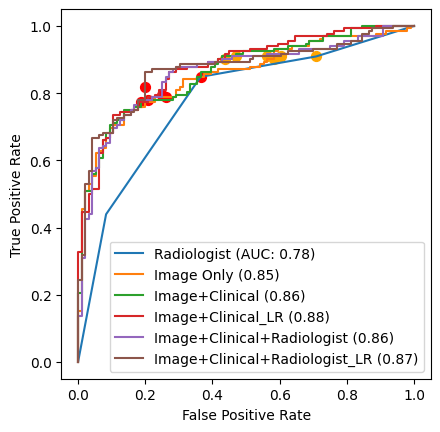

In [11]:
# for only pathology proven cases
print('test set, path proven cases')
total_positive = (df_test_path_only['Final_Dx'] == 1).sum()
total_negative = (df_test_path_only['Final_Dx'] == 0).sum()
print('total positive: '
      + str(total_positive)
      + ', total negative: '
      + str(total_negative))
# PIRADS
variable = 'PIRADS'
fpr, tpr, threshold = metrics.roc_curve(
    df_test_path_only['Final_Dx'],
    df_test_path_only[variable])
roc_auc = metrics.auc(fpr, tpr)
print(label_dict[variable])
print('AUC: ' + '{0:.3f}'.format(roc_auc))
PIRADS3_tpr, PIRADS3_fpr = tpr[3], fpr[3]
PIRADS4_tpr, PIRADS4_fpr = tpr[2], fpr[2]
print_tpr_fpr(
    'PIRADS3', PIRADS3_tpr, PIRADS3_fpr, total_positive, total_negative)
print_tpr_fpr(
    'PIRADS4', PIRADS4_tpr, PIRADS4_fpr, total_positive, total_negative)
plt.plot(fpr, tpr,
    label=label_dict[variable] + ' (AUC: ' + '{0:.2f}'.format(roc_auc) + ')')
plt.scatter(PIRADS3_fpr, PIRADS3_tpr, marker='o', color='orange', s=50)
plt.scatter(PIRADS4_fpr, PIRADS4_tpr, marker='o', color='red', s=50)

# Other Variables
for variable in variable_list:
    fpr, tpr, threshold = metrics.roc_curve(
        df_test_path_only['Final_Dx'],
        df_test_path_only[variable])
    roc_auc = metrics.auc(fpr, tpr)
    print(label_dict[variable])
    print('AUC: ' + '{0:.3f}'.format(roc_auc))
    #calculate FPR with same TPR as PIRADS3
    PIRADS3_equiv_threshold = threshold[(tpr <= PIRADS3_tpr).sum() - 1]
    PIRADS3_equiv_tpr, PIRADS3_equiv_fpr = get_tpr_fpr(
        df_test_path_only, variable, PIRADS3_equiv_threshold)
    print_tpr_fpr(
        'PIRADS3 equivalent',
        PIRADS3_equiv_tpr, PIRADS3_equiv_fpr,
        total_positive, total_negative)
    mcn_chi, mcn_p = McNemar_test(
        (df_test_path_only[variable]>=PIRADS3_equiv_threshold),
        (df_test_path_only['PIRADS']>=3),
        df_test_path_only['Final_Dx'])
    print('McNemar: P=' + '{0:.5f}'.format(mcn_p))
    yoden_tpr, yoden_fpr = get_tpr_fpr(
        df_test_path_only, variable, yoden_threshold_all[variable])
    print_tpr_fpr(
        'Yoden', yoden_tpr, yoden_fpr, total_positive, total_negative)
    mcn_chi, mcn_p = McNemar_test(
        (df_test_path_only[variable]>=yoden_threshold_all[variable]),
        (df_test_path_only['PIRADS']>=4),
        df_test_path_only['Final_Dx'])
    print('McNemar: P=' + '{0:.5f}'.format(mcn_p))
    plt.plot(fpr, tpr,
        label=label_dict[variable] + ' (' + '{0:.2f}'.format(roc_auc) + ')')
    plt.scatter(
        yoden_fpr, yoden_tpr, marker='o', color='red', s=50)
    plt.scatter(
        PIRADS3_equiv_fpr, PIRADS3_equiv_tpr, marker='o', color='orange', s=50)
    yoden_tpr, yoden_fpr = get_tpr_fpr(
        df_test_path_only, variable, yoden_threshold_path[variable])
    print_tpr_fpr(
        'Yoden (path only)',
        yoden_tpr, yoden_fpr, total_positive, total_negative)
#clinical preds:
fpr, tpr, threshold = metrics.roc_curve(
    df_test_path_only.loc[~df_test_path_only['clinical'].isnull(), 'Final_Dx'],
    df_test_path_only.loc[~df_test_path_only['clinical'].isnull(), 'clinical'])
roc_auc = metrics.auc(fpr, tpr)
print('Clinical')
print('AUC: ' + '{0:.3f}'.format(roc_auc))

plt.axis('square')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

test set, external
total positive: 70, total negative: 134
Radiologist
AUC: 0.844
PIRADS3 tpr, fpr: 0.929 (65/70), 0.358 (48/134)
PIRADS4 tpr, fpr: 0.871 (61/70), 0.246 (33/134)
Image Only
AUC: 0.856
PIRADS3 equivalent tpr, fpr: 0.929 (65/70), 0.403 (54/134)
McNemar: P=0.42959
Yoden tpr, fpr: 0.829 (58/70), 0.269 (36/134)
McNemar: P=0.45138
Image+Radiologist
AUC: 0.885
PIRADS3 equivalent tpr, fpr: 0.929 (65/70), 0.336 (45/134)
McNemar: P=0.54883
Yoden tpr, fpr: 0.914 (64/70), 0.231 (31/134)
McNemar: P=0.33231


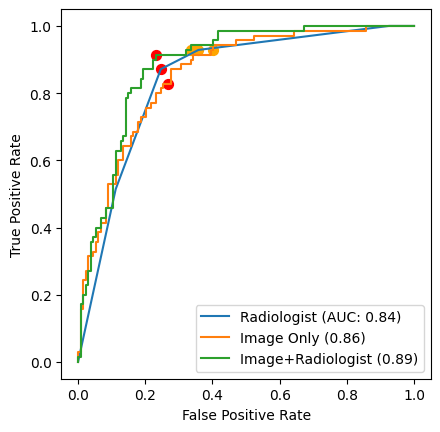

In [12]:
# external
print('test set, external')
total_positive = (df_test_external['Final_Dx'] == 1).sum()
total_negative = (df_test_external['Final_Dx'] == 0).sum()
print('total positive: '
      + str(total_positive)
      + ', total negative: '
      + str(total_negative))

variable = 'PIRADS'
fpr, tpr, threshold = metrics.roc_curve(
    df_test_external['Final_Dx'],
    df_test_external[variable])
roc_auc = metrics.auc(fpr, tpr)
print(label_dict[variable])
print('AUC: ' + '{0:.3f}'.format(roc_auc))
PIRADS3_tpr, PIRADS3_fpr = tpr[3], fpr[3]
PIRADS4_tpr, PIRADS4_fpr = tpr[2], fpr[2]
print_tpr_fpr(
    'PIRADS3', PIRADS3_tpr, PIRADS3_fpr, total_positive, total_negative)
print_tpr_fpr(
    'PIRADS4', PIRADS4_tpr, PIRADS4_fpr, total_positive, total_negative)
plt.plot(fpr, tpr,
    label=label_dict[variable] + ' (AUC: ' + '{0:.2f}'.format(roc_auc) + ')')
plt.scatter(PIRADS3_fpr, PIRADS3_tpr, marker='o', color='orange', s=50)
plt.scatter(PIRADS4_fpr, PIRADS4_tpr, marker='o', color='red', s=50)

for variable in variable_list2:
    fpr, tpr, threshold = metrics.roc_curve(
        df_test_external['Final_Dx'],
        df_test_external[variable])
    roc_auc = metrics.auc(fpr, tpr)
    print(label_dict[variable])
    print('AUC: ' + '{0:.3f}'.format(roc_auc))
    #calculate FPR with same TPR as PIRADS3
    PIRADS3_equiv_threshold = threshold[(tpr <= PIRADS3_tpr).sum() - 1]
    PIRADS3_equiv_tpr, PIRADS3_equiv_fpr = get_tpr_fpr(
        df_test_external, variable, PIRADS3_equiv_threshold)
    print_tpr_fpr(
        'PIRADS3 equivalent',
        PIRADS3_equiv_tpr, PIRADS3_equiv_fpr,
        total_positive, total_negative)
    mcn_chi, mcn_p = McNemar_test(
        (df_test_external[variable]>=PIRADS3_equiv_threshold),
        (df_test_external['PIRADS']>=3),
        df_test_external['Final_Dx'])
    print('McNemar: P=' + '{0:.5f}'.format(mcn_p))
    yoden_tpr, yoden_fpr = get_tpr_fpr(
        df_test_external, variable, yoden_threshold_all[variable])
    print_tpr_fpr(
        'Yoden', yoden_tpr, yoden_fpr, total_positive, total_negative)
    mcn_chi, mcn_p = McNemar_test(
        (df_test_external[variable]>=yoden_threshold_all[variable]),
        (df_test_external['PIRADS']>=4),
        df_test_external['Final_Dx'])
    print('McNemar: P=' + '{0:.5f}'.format(mcn_p))
    plt.plot(fpr, tpr,
        label=label_dict[variable] + ' (' + '{0:.2f}'.format(roc_auc) + ')')
    plt.scatter(
        yoden_fpr, yoden_tpr, marker='o', color='red', s=50)
    plt.scatter(
        PIRADS3_equiv_fpr, PIRADS3_equiv_tpr, marker='o', color='orange', s=50)
plt.axis('square')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [13]:
# all cases
variable_list3 = ['PIRADS'] + variable_list
roc = pyroc.ROC(
    df_test['Final_Dx'],
    df_test[variable_list3])
auc = {pred_name: roc.auc[0, i] for i, pred_name in enumerate(roc.preds.keys())}

num_bootstrap = 1000
num_samples = df_test.shape[0]
index_all = np.arange(num_samples)
bootstrap_auc = {}
for variable in variable_list3:
    bootstrap_auc[variable] = np.array([])
for idx1 in range(num_bootstrap):
    sampled = resample(index_all, n_samples=num_samples)
    df_sampled = df_test.iloc[sampled]
    df_sampled = df_test.iloc[sampled]
    for variable in variable_list3:
        fpr, tpr, threshold = metrics.roc_curve(
            df_sampled['Final_Dx'],
            df_sampled[variable])
        roc_auc = metrics.auc(fpr, tpr)
        bootstrap_auc[variable] = np.append(bootstrap_auc[variable],roc_auc)
for variable in variable_list3:
    print(label_dict[variable])
    print_var_95ci('AUC (bs)',
             np.mean(bootstrap_auc[variable]),
             np.percentile(bootstrap_auc[variable], 5),
             np.percentile(bootstrap_auc[variable], 95)
            )

for i, variable in enumerate(variable_list3):
    print(label_dict[variable])
    print_var_95ci(
        'AUC (PyROC)', auc[variable], roc.ci()[0][i], roc.ci()[1][i])
for i in range(len(variable_list3) -1):
    contrast = [-1, 0, 0, 0, 0, 0]
    contrast[i+1] = 1
    p, ci = roc.compare(np.array([contrast,]))
    print('Radiologist vs ' + label_dict[variable_list3[i+1]] + ': p=' + '{0:.5f}'.format(p))

Radiologist
AUC (bs): 0.892 (95% CI: 0.862, 0.920)
Image Only
AUC (bs): 0.888 (95% CI: 0.856, 0.917)
Image+Clinical
AUC (bs): 0.900 (95% CI: 0.871, 0.925)
Image+Clinical_LR
AUC (bs): 0.906 (95% CI: 0.879, 0.931)
Image+Clinical+Radiologist
AUC (bs): 0.934 (95% CI: 0.911, 0.955)
Image+Clinical+Radiologist_LR
AUC (bs): 0.938 (95% CI: 0.916, 0.958)
Radiologist
AUC (PyROC): 0.892 (95% CI: 0.858, 0.926)
Image Only
AUC (PyROC): 0.889 (95% CI: 0.852, 0.926)
Image+Clinical
AUC (PyROC): 0.900 (95% CI: 0.867, 0.934)
Image+Clinical_LR
AUC (PyROC): 0.907 (95% CI: 0.875, 0.938)
Image+Clinical+Radiologist
AUC (PyROC): 0.935 (95% CI: 0.909, 0.961)
Image+Clinical+Radiologist_LR
AUC (PyROC): 0.939 (95% CI: 0.913, 0.964)
Radiologist vs Image Only: p=0.88459
Radiologist vs Image+Clinical: p=0.66461
Radiologist vs Image+Clinical_LR: p=0.42229
Radiologist vs Image+Clinical+Radiologist: p=0.00000
Radiologist vs Image+Clinical+Radiologist_LR: p=0.00000


In [14]:
# pathology only
roc = pyroc.ROC(
    df_test_path_only['Final_Dx'],
    df_test_path_only[variable_list3])
auc = {pred_name: roc.auc[0, i] for i, pred_name in enumerate(roc.preds.keys())}

num_bootstrap = 1000
num_samples = df_test_path_only.shape[0]
index_all = np.arange(num_samples)
bootstrap_auc = {}
for variable in variable_list3:
    bootstrap_auc[variable] = np.array([])
for idx1 in range(num_bootstrap):
    sampled = resample(index_all, n_samples=num_samples)
    df_sampled = df_test_path_only.iloc[sampled]
    df_sampled = df_test_path_only.iloc[sampled]
    for variable in variable_list3:
        fpr, tpr, threshold = metrics.roc_curve(
            df_sampled['Final_Dx'],
            df_sampled[variable])
        roc_auc = metrics.auc(fpr, tpr)
        bootstrap_auc[variable] = np.append(bootstrap_auc[variable],roc_auc)
for variable in variable_list3:
    print(label_dict[variable])
    print_var_95ci('AUC (bs)',
             np.mean(bootstrap_auc[variable]),
             np.percentile(bootstrap_auc[variable], 5),
             np.percentile(bootstrap_auc[variable], 95)
            )
for i, variable in enumerate(variable_list3):
    print(label_dict[variable])
    print_var_95ci(
        'AUC (PyROC)', auc[variable], roc.ci()[0][i], roc.ci()[1][i])
for i in range(len(variable_list3)-1):
    contrast = [-1, 0, 0, 0, 0, 0]
    contrast[i+1] = 1
    p, ci = roc.compare(np.array([contrast,]))
    print(
        'Radiologist vs '
        + label_dict[variable_list3[i+1]]
        + ': p=' + '{0:.5f}'.format(p))

Radiologist
AUC (bs): 0.780 (95% CI: 0.731, 0.825)
Image Only
AUC (bs): 0.853 (95% CI: 0.809, 0.895)
Image+Clinical
AUC (bs): 0.863 (95% CI: 0.824, 0.904)
Image+Clinical_LR
AUC (bs): 0.876 (95% CI: 0.839, 0.911)
Image+Clinical+Radiologist
AUC (bs): 0.858 (95% CI: 0.817, 0.897)
Image+Clinical+Radiologist_LR
AUC (bs): 0.869 (95% CI: 0.830, 0.906)
Radiologist
AUC (PyROC): 0.780 (95% CI: 0.721, 0.838)
Image Only
AUC (PyROC): 0.853 (95% CI: 0.803, 0.902)
Image+Clinical
AUC (PyROC): 0.863 (95% CI: 0.816, 0.909)
Image+Clinical_LR
AUC (PyROC): 0.876 (95% CI: 0.832, 0.920)
Image+Clinical+Radiologist
AUC (PyROC): 0.858 (95% CI: 0.809, 0.907)
Image+Clinical+Radiologist_LR
AUC (PyROC): 0.869 (95% CI: 0.822, 0.917)
Radiologist vs Image Only: p=0.01424
Radiologist vs Image+Clinical: p=0.00459
Radiologist vs Image+Clinical_LR: p=0.00109
Radiologist vs Image+Clinical+Radiologist: p=0.00000
Radiologist vs Image+Clinical+Radiologist_LR: p=0.00000


In [15]:
# external test set
variable_list4 = ['PIRADS'] + variable_list2
roc = pyroc.ROC(
    df_test_external['Final_Dx'],
    df_test_external[variable_list4])
auc = {pred_name: roc.auc[0, i] for i, pred_name in enumerate(roc.preds.keys())}

num_bootstrap = 1000
num_samples = df_test_external.shape[0]
index_all = np.arange(num_samples)
bootstrap_auc = {}
for variable in variable_list4:
    bootstrap_auc[variable] = np.array([])
for idx1 in range(num_bootstrap):
    sampled = resample(index_all, n_samples=num_samples)
    df_sampled = df_test_external.iloc[sampled]
    df_sampled = df_test_external.iloc[sampled]
    for variable in variable_list4:
        fpr, tpr, threshold = metrics.roc_curve(
            df_sampled['Final_Dx'],
            df_sampled[variable])
        roc_auc = metrics.auc(fpr, tpr)
        bootstrap_auc[variable] = np.append(bootstrap_auc[variable],roc_auc)
for variable in variable_list4:
    print(label_dict[variable])
    print_var_95ci('AUC (bs)',
             np.mean(bootstrap_auc[variable]),
             np.percentile(bootstrap_auc[variable], 5),
             np.percentile(bootstrap_auc[variable], 95)
            )

for i, variable in enumerate(variable_list4):
    print(label_dict[variable])
    print_var_95ci(
        'AUC (PyROC)', auc[variable], roc.ci()[0][i], roc.ci()[1][i])
for i in range(len(variable_list4)-1):
    contrast = [-1, 0, 0]
    contrast[i+1] = 1
    p, ci = roc.compare(np.array([contrast,]))
    print(
        'Radiologist vs '
        + label_dict[variable_list4[i+1]]
        + ': p=' + '{0:.5f}'.format(p))

Radiologist
AUC (bs): 0.844 (95% CI: 0.798, 0.887)
Image Only
AUC (bs): 0.855 (95% CI: 0.811, 0.898)
Image+Radiologist
AUC (bs): 0.884 (95% CI: 0.848, 0.921)
Radiologist
AUC (PyROC): 0.844 (95% CI: 0.791, 0.897)
Image Only
AUC (PyROC): 0.856 (95% CI: 0.804, 0.908)
Image+Radiologist
AUC (PyROC): 0.885 (95% CI: 0.840, 0.930)
Radiologist vs Image Only: p=0.67875
Radiologist vs Image+Radiologist: p=0.00023


In [16]:
# test set (all), clinical data 95% CI
df_test_clinical = df_test[~df_test['clinical'].isnull()]
roc = pyroc.ROC(
    df_test_clinical['Final_Dx'],
    df_test_clinical['clinical'])
auc = roc.auc[0]
print(label_dict['clinical'])
print_var_95ci('AUC (PyROC)', auc[0], roc.ci()[0][0], roc.ci()[1][0])

num_bootstrap = 1000
num_samples = df_test_clinical.shape[0]
index_all = np.arange(num_samples)
bootstrap_auc = np.array([])
for idx1 in range(num_bootstrap):
    sampled = resample(index_all, n_samples=num_samples)
    df_sampled = df_test_clinical.iloc[sampled]
    df_sampled = df_test_clinical.iloc[sampled]
    fpr, tpr, threshold = metrics.roc_curve(
        df_sampled['Final_Dx'],
        df_sampled['clinical'])
    roc_auc = metrics.auc(fpr, tpr)
    bootstrap_auc = np.append(bootstrap_auc, roc_auc)
print_var_95ci('AUC (bs)',
            np.mean(bootstrap_auc),
            np.percentile(bootstrap_auc, 5),
            np.percentile(bootstrap_auc, 95)
        )

Clinical
AUC (PyROC): 0.814 (95% CI: 0.763, 0.864)
AUC (bs): 0.815 (95% CI: 0.771, 0.853)


In [17]:
# test set (path only), clinical data 95% CI
df_test_path_only_clinical = df_test_path_only[
    ~df_test_path_only['clinical'].isnull()]
roc = pyroc.ROC(
    df_test_path_only_clinical['Final_Dx'],
    df_test_path_only_clinical['clinical'])
auc = roc.auc[0]
print(label_dict['clinical'])
print_var_95ci('AUC (PyROC)', auc[0], roc.ci()[0][0], roc.ci()[1][0])
num_bootstrap = 1000
num_samples = df_test_path_only_clinical.shape[0]
index_all = np.arange(num_samples)
bootstrap_auc = np.array([])
for idx1 in range(num_bootstrap):
    sampled = resample(index_all, n_samples=num_samples)
    df_sampled = df_test_path_only_clinical.iloc[sampled]
    df_sampled = df_test_path_only_clinical.iloc[sampled]
    fpr, tpr, threshold = metrics.roc_curve(
        df_sampled['Final_Dx'],
        df_sampled['clinical'])
    roc_auc = metrics.auc(fpr, tpr)
    bootstrap_auc = np.append(bootstrap_auc, roc_auc)
print_var_95ci('AUC (bs)',
            np.mean(bootstrap_auc),
            np.percentile(bootstrap_auc, 5),
            np.percentile(bootstrap_auc, 95)
        )

Clinical
AUC (PyROC): 0.772 (95% CI: 0.702, 0.843)
AUC (bs): 0.771 (95% CI: 0.713, 0.829)


In [18]:
print('Yoden threshold, all cases')
for key, value in yoden_threshold_all.items():
    print(label_dict[key] + ' ' + '{0:.3f}'.format(value))
print('Yoden threshold, path only cases')
for key, value in yoden_threshold_path.items():
    print(label_dict[key] + ' ' + '{0:.3f}'.format(value))

Yoden threshold, all cases
Image Only 0.304
Image+Clinical 0.376
Image+Clinical_LR 0.352
Image+Clinical+Radiologist 0.399
Image+Clinical+Radiologist_LR 0.368
Radiologist 3.000
Image+Radiologist 0.264
Yoden threshold, path only cases
Image Only 0.326
Image+Clinical 0.386
Image+Clinical_LR 0.375
Image+Clinical+Radiologist 0.492
Image+Clinical+Radiologist_LR 0.368
Radiologist 4.000
